## Double Machine Learning (DML) CATE Estimators

In [93]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV

# DoWhy imports 
import dowhy
from dowhy import CausalModel

# EconML imports
from econml.dml import LinearDML, CausalForestDML
from econml.iv.dr import LinearIntentToTreatDRIV

from econml.inference import BootstrapInference
from econml.cate_interpreter import SingleTreeCateInterpreter, \
                                    SingleTreePolicyInterpreter

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Custom DoWhy helper functions
from pathlib import Path
import os
import sys
cwd = Path().resolve()
PARENT_DIR = os.path.dirname(cwd)
SCRIPT_DIR = os.path.join(PARENT_DIR, 'helpers')
sys.path.append(SCRIPT_DIR)
import dowhy_helpers as dwh

In [62]:
# I/O Stuff
DATA_FILENAME = "csdh_clean.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

---
## 0. Naïve ATE Estimation (no causal inference)

In [63]:
naive_est = dwh.naive_estimate(df=csdh, treatment='drain', outcome='recurrence', treatment_type='int')
print(f"Without adjusting for any confounding, the naive causal estimate is computed as {naive_est}")

Without adjusting for any confounding, the naive causal estimate is computed as -0.09356128931064231


---

In [70]:
T = csdh['drain'].values
Y = csdh['recurrence'].values
X = csdh[['thickness_sum']].values

confounder_names = ['adm_mrs', 'gcs_preop', 'antiplatelet', 'age']
W = csdh[confounder_names].values

In [92]:
# initiate an EconML cate estimator
est = DML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor(),
              featurizer=PolynomialFeatures(degree=2, include_bias=False))

TypeError: __init__() missing 1 required keyword-only argument: 'model_final'

In [72]:
# fit through dowhy
est_dw = est.dowhy.fit(Y, T, X=X, W=W, outcome_names=["recurrence"], treatment_names=["drain"], feature_names=["thickness_sum"],
                       graph='../causal_graphs/mp_dag.dot'.replace("\n", " "),
               confounder_names=confounder_names, inference="statsmodels")

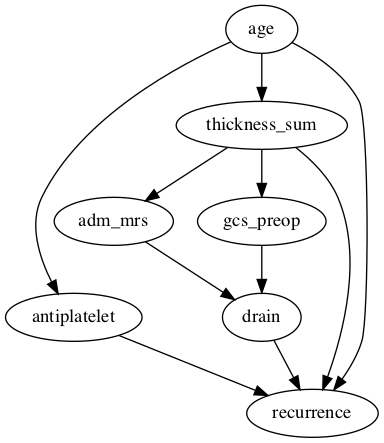

In [73]:
# Visualize causal graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(
        Image(to_pydot(est_dw._graph._graph).create_png())
    )
except:
    # Fall back on default graph view
    est_dw.view_model()

In [74]:
identified_estimand = est_dw.identified_estimand_
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|thickness_sum,antiplatelet,adm_mrs,age,gcs_pre
d[drain]                                                                      

    
op))
    
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,thickness_sum,antiplatelet,adm_mrs,age,gcs_preop,U) = P(recurrence|drain,thickness_sum,antiplatelet,adm_mrs,age,gcs_preop)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [75]:
lineardml_estimate = est_dw.estimate_
print(lineardml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|thickness_sum,antiplatelet,adm_mrs,age,gcs_pre
d[drain]                                                                      

    
op))
    
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,thickness_sum,antiplatelet,adm_mrs,age,gcs_preop,U) = P(recurrence|drain,thickness_sum,antiplatelet,adm_mrs,age,gcs_preop)

## Realized estimand
b: recurrence~drain+thickness_sum+antiplatelet+adm_mrs+age+gcs_preop | thickness_sum
Target units: ate

## Estimate
Mean value: -0.12190083933921171
Effect estimates: [-0.12331932  0.02614344 -0.1359363  -0.00175952 -0.02747876 -0.16456711
 -0.02747876 -0.15076731 -0.00175952 -0.09153423 -0.0510143  -0.07236612
 -0.02747876 -0.01489211 -0.06196317 -0.1002994  -

In [77]:
# Get the final coefficient and intercept summary
est_dw.summary(feature_names=["thickness_sum"])

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
thickness_sum,-0.018,0.009,-1.902,0.057,-0.033,-0.002
thickness_sum^2,0.0,0.0,1.852,0.064,0.0,0.001
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,0.123,0.121,1.016,0.31,-0.076,0.322


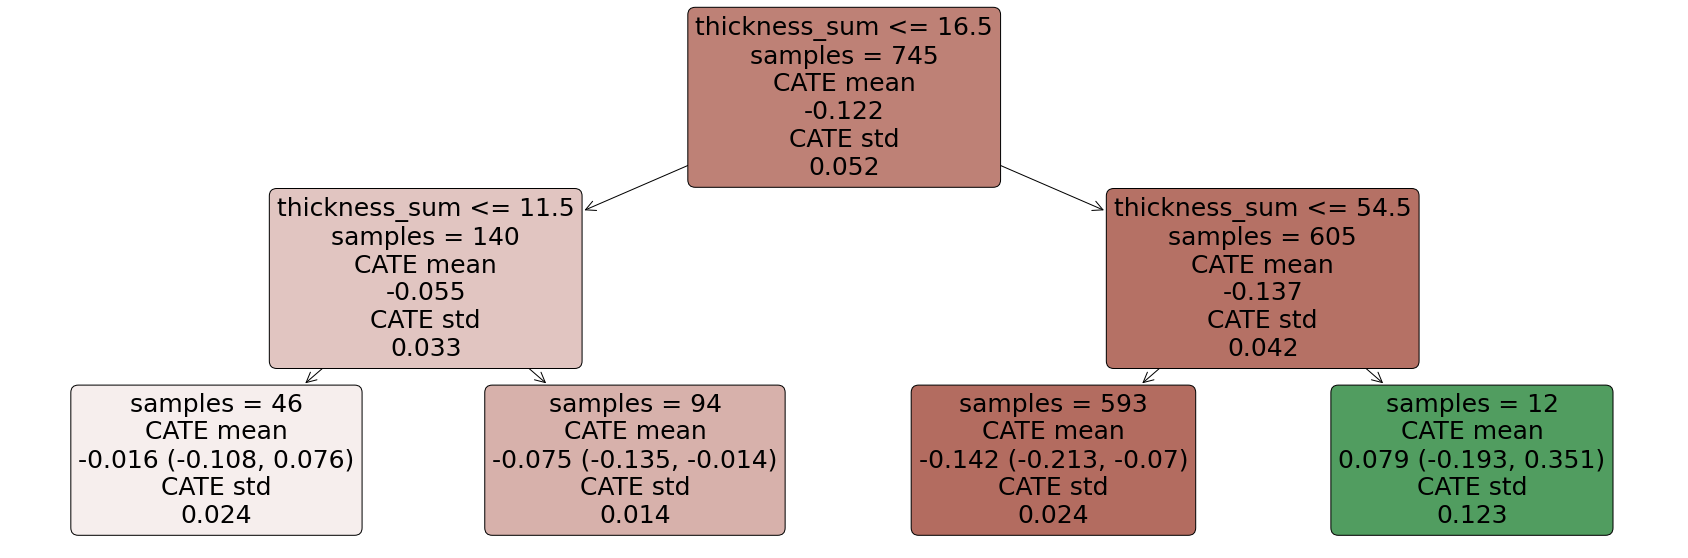

In [84]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(est_dw, X)
plt.figure(figsize=(30, 10))
intrp.plot(feature_names=["thickness_sum"], fontsize=25)